# NBA Player Clusters

The purpose of this analysis is to examine the "true" positions in the NBA based on player statistics rather than based on the traditional position classifications of Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C). 

The dataset used is season stats compiled from basketball-reference.com from the 2016-17 season. Only players who logged more than 500 minutes were used. Stats were compiled on a per 100 possession basis, so players who played more often did not seem different than players who may be the same type, but simply had less time to log counting stats. Advanced metrics like PER were also used. Colinear columns were also removed.

Each player has many different statistics associated with them. Both in order to better visualize the feature space and to define new player attribute dimensions, it will be necessary to perform dimensionality reduction. The analysis will use PCA or LDA for this purpose, and the superior method will be used for determining the new feature space where players will be clustered.

K-means clustering will be used on the new feature space and the best K will be selected based on silhouette score.

## Required Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

## Import and Examine Data

In [28]:
# Import the Data
data = pd.read_csv('season_stats.csv')

In [29]:
pd.set_option('display.max_columns', 999)
data.head()

,Player,Pos,Age,Tm,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%
0,Alex Abrines\abrinal01,SG,23,OKC,4.4,11.5,1.9,4.4,2.0,2.3,0.8,3.2,4.0,1.9,1.7,0.4,1.5,5.3,18.9,113,110,9.0,0.573,0.722,0.205,2.6,9.5,5.9,3.1,1.6,0.5,9.4,13.1
1,Quincy Acy\acyqu01,PF,26,BRK,3.3,7.7,2.7,6.5,4.0,5.3,1.7,8.3,9.9,1.7,1.3,1.4,1.8,5.4,19.4,113,110,7.0,0.504,0.779,0.201,3.4,18.9,11.1,4.7,1.1,1.3,15.6,14.4
2,Steven Adams\adamsst01,C,23,OKC,0.0,0.0,7.7,13.4,3.2,5.3,5.8,6.8,12.6,1.8,1.8,1.6,3.0,4.0,18.6,114,107,21.5,0.639,0.004,0.346,17.8,13.8,15.8,4.7,1.8,2.9,12.7,16.7
3,Arron Afflalo\afflaar01,SG,31,SAC,2.0,4.8,3.9,8.6,2.7,3.0,0.3,3.7,4.0,2.5,0.7,0.2,1.3,3.3,16.5,109,116,4.9,0.497,0.406,0.189,0.7,9.6,5.1,5.4,0.2,0.8,10.2,11.7
4,Cole Aldrich\aldrico01,C,28,MIN,0.0,0.0,4.3,8.2,1.4,2.1,4.9,10.2,15.1,2.4,2.4,2.2,1.6,8.1,10.0,118,107,9.2,0.372,0.000,0.444,12.3,16.9,14.6,4.8,3.6,3.2,8.5,18.6


Here is a quick description of each statistic collected (all counting stats per 100 possessions):
 - 3P: 3 point field goals made
 - 3PA: 3 point field goals attempted
 - 2P: 2 point field goals made
 - 2PA: 2 point field goals attempted
 - FT: Free throws made
 - FTA: Free throws attempted
 - ORB: Offensive rebounds
 - DRB: Defensive rebounds
 - TRB: Total rebounds
 - AST: Assists
 - STL: Steals
 - BLK: Blocks
 - TOV: Turnovers
 - PF: Personal fouls
 - PTS: Points scored
 - ORtg: Offensive rating
 - DRtg: Defensive rating
 - PER: Player efficiency rating
 - TS%: True shooting percentage
 - 3PAr: Three point attempt rate (3PA/FGA)
 - FTr: Free throw attempt rate (FTA/FGA)
 - ORB%: Offensive rebound percentage
 - DRB%: Defensive rebound percentage
 - TRB%: Total rebound percentage
 - AST%: Percent of field goals the player assisted while on the floor
 - STL%: Percent of opponent possessions that end in a steal when players is on the floor
 - BLK%: Percent of opponent field goals blocked by player while he is on the floor
 - TOV%: Turnover percentage committed by player
 - USG%: Percentage of possessions a player was involved in

## Dimensionality Reduction

First, we need to encode the current position column into numeric values before running any analysis. We also set columns to exclude such as the player name, team, and age. We will also scale each column using a min-max scaler since many of the columns are on different scales. This scaling will prevent any bias towards columns with naturally larger values.

In [31]:
# Encode current position (POS) column
le = LabelEncoder()
positions = data['Pos'].unique().tolist()
data['Pos_'] = le.fit_transform(data['Pos'])

exclude = ['Player', 'Tm', 'Pos', 'Pos_', 'Age', 'PTS', 'TRB', 'TRB%', 'PER']
y = data['Pos_']
X = data.drop(exclude, axis=1)
scaled_X = MinMaxScaler().fit_transform(X)

Next, we fit an LDA model on the data using the old position as the target. We also fit PCA on the features, ignoring old positions.

In [32]:
# Perform linear discriminant analysis for dimensionality reduction
lda = LinearDiscriminantAnalysis()
lda_X = lda.fit_transform(scaled_X, y)

# Perform PCA for dimensionality reduction
pca = PCA()
pca_X = pca.fit_transform(scaled_X)

Both LDA and PCA were examined and the PCA section is removed. LDA proved to find more meaningful components than PCA. The first 2 components found by LDA explain roughly 95% of the variance in player position. PCA required more components, and hence more complexity, to describe as much variance in the data.

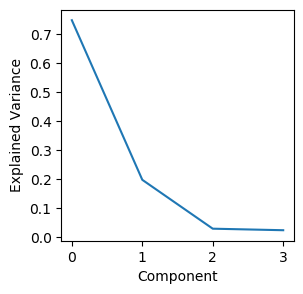

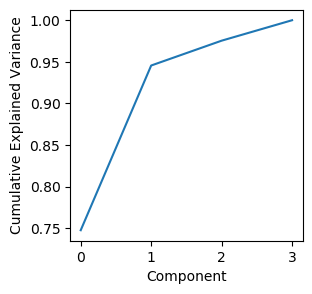

In [33]:
explained_variance = lda.explained_variance_ratio_
plt.figure(1, figsize=(3,3))
plt.plot(explained_variance)
plt.ylabel('Explained Variance')
plt.xlabel('Component')

plt.figure(2, figsize=(3,3))
plt.plot(np.cumsum(explained_variance))
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Component')
plt.show()

First 2 components explain ~95% of the variance

Here we restrict the LDA model to find exactly 2 components. And examine the results.

In [34]:
lda2 = LinearDiscriminantAnalysis(n_components = 2)
lda_X = lda2.fit_transform(scaled_X, y)

<Figure size 640x480 with 0 Axes>

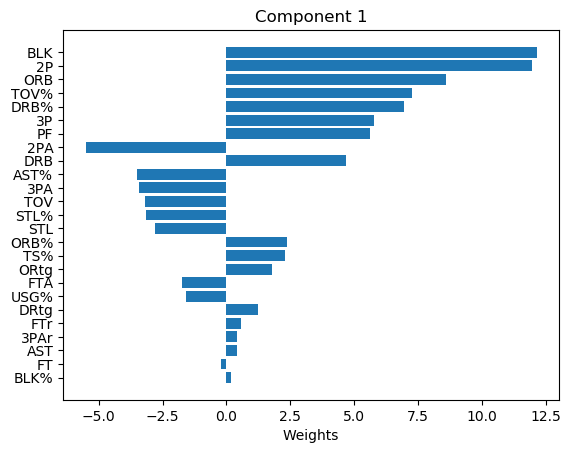

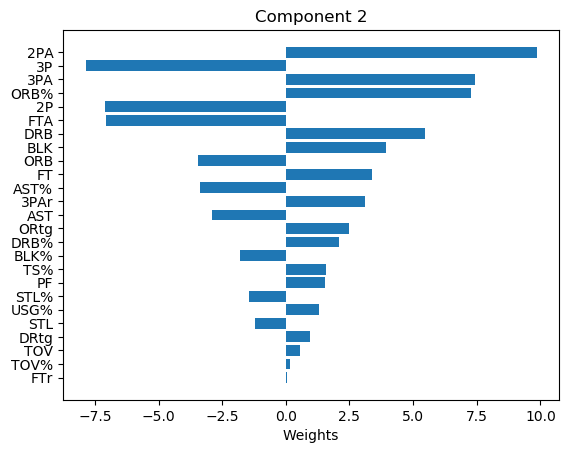

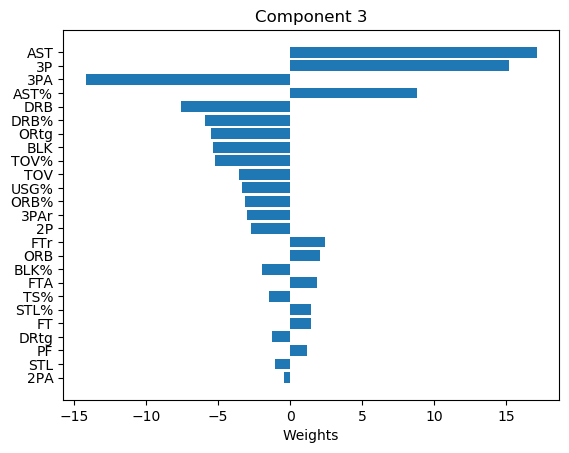

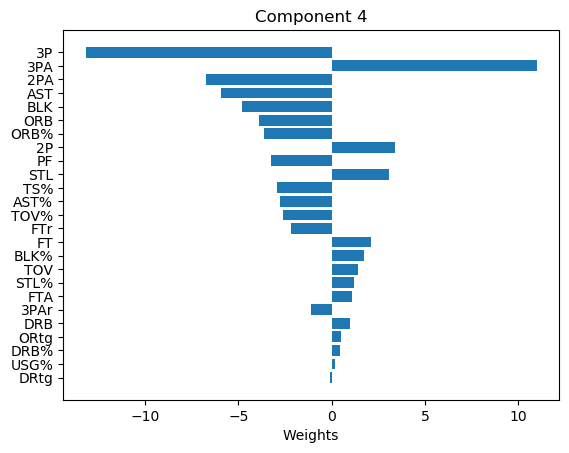

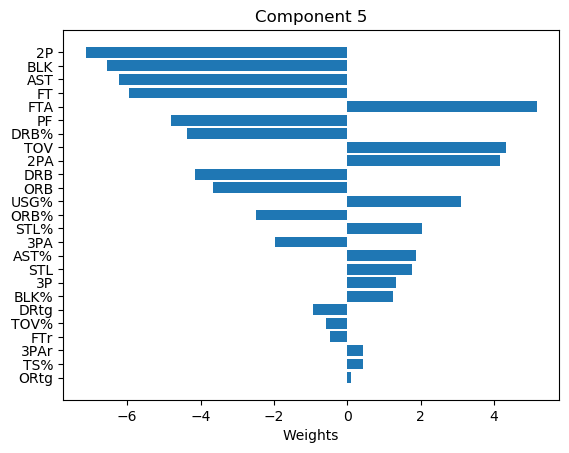

In [35]:
for i, weights in enumerate(lda.coef_):
    plt.figure(i+1)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    
    features = X.columns
    
    df = pd.DataFrame({'features':features,
                      'weights':weights,
                      'abs':abs(weights)})
    
    df.sort_values(by='abs', ascending=False, inplace=True)
    
    weights = df['weights']
    features = df['features']
    
    y_pos = np.arange(len(features))

    ax.barh(y_pos, weights, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Weights')
    ax.set_title('Component {}'.format(i+1))

plt.show()

Both components are difficult to interpret due to the fact that they try to combine all aspects of a player's game into two dimensions. The best way to examine how to interpret the dimensions is to see what kinds of players score high or low on each. We can examine the weights here to make a couple heuristics.\
\
The first component describes **how involved** a player may be. These players have many blocks and rebounds and are active on defense. This dimension also captures scoring, so players high in component 1 probably get more playing time and score more often. These players also have a higher turnover percentage, meaning they probably have the ball more often.\
\
The second component can be thought of as **offensive-minded players**. These players attempt more shots and have a high offensive rating. They also have high rebound rates, especially on offense.

## Clustering

Now that we have two dimensions in our feature space - one that roughly describes how involved a player is and another that describes how close to the rim he plays - we can plot each player on this space and cluster them based on how near to each other they are. We will examine 3 clusters up to 8 clusters and will see which number of clusters best divides the data.

In [36]:
# Visualize the clustering
def plot_clustering(lda_X, labels, n_clusters, title=None):
    plt.figure(figsize=(4,3))
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'lavender', 'green', 'aqua', 'gold']
    colors = colors[:n_clusters]
    lw = 2
    for color, i, position in zip(colors, list(range(n_clusters)), list(range(n_clusters))):
        plt.scatter(lda_X[labels == i, 0], lda_X[labels == i, 1], alpha=.8, color=color,
                    label=position)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

For n_clusters = 3 The average silhouette_score is : 0.4969144729353976
For n_clusters = 4 The average silhouette_score is : 0.42859680130691435
For n_clusters = 5 The average silhouette_score is : 0.40383726089403815
For n_clusters = 6 The average silhouette_score is : 0.3982277006263098
For n_clusters = 7 The average silhouette_score is : 0.38324938310344814
For n_clusters = 8 The average silhouette_score is : 0.375071442816237


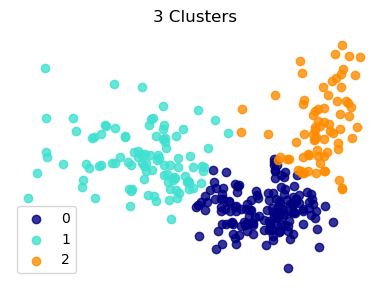

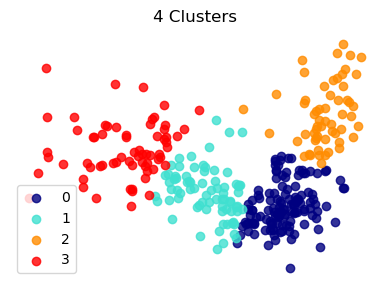

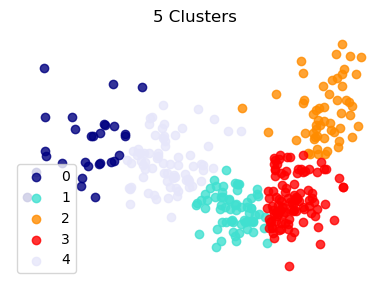

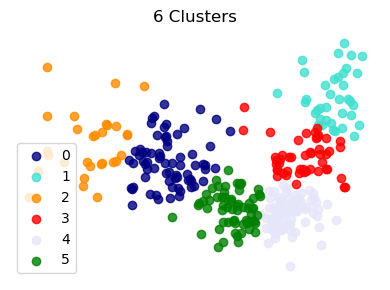

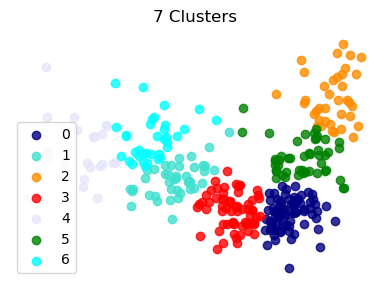

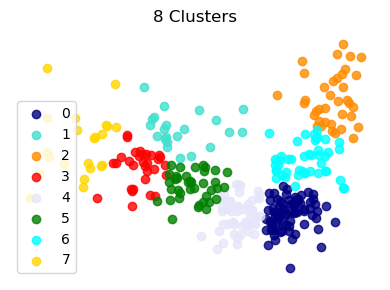

In [37]:
# Cluster the data using K-means for different k, compute silhouette score
k_list = list(range(3, 9))

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(lda_X)
    sil_avg = silhouette_score(lda_X, labels)
    plot_clustering(lda_X, labels, k, title='{} Clusters'.format(k))
    print("For n_clusters =", k,
      "The average silhouette_score is :", sil_avg)

plt.show()

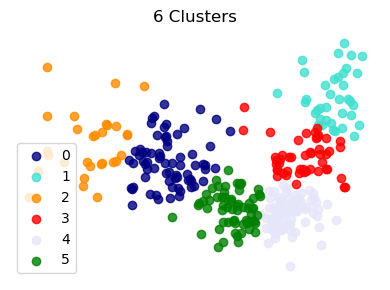

In [38]:
kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(lda_X)
sil_avg = silhouette_score(lda_X, labels)
plot_clustering(lda_X, labels, 6, title='{} Clusters'.format(6))

plt.show()

Silhouette score will naturally decrease as the number of clusters increases, but the sharpest decline is between 6 and 7 clusters. Therefore, we will say that 6 is the best number of clusters that divides the data and is the new number of true positions in the NBA.\
\
Based on our earlier characterizations of the dimensions, players that fall to the right of the chart are very involved in both offense and defense and players towards the left of the chart are not. Players nearer to the top have offensive prowess and take more shots and those towards the bottom are most likely more defensively minded.\
\
The players form almost a U shape in the feature space, indicating that players on the far right and left of the chart (many touches or not many touches) also tend to be offensively minded, whereas players that fall more in the middle of the x-axis tend to be more consistent role players.\
\
Cluster 1, or the top right most cluster, is our high-scoring point guard. These players have the ball a lot and they also score a lot. They are involved in many plays and are probably players like Steph Curry or Russell Westbrook. Cluster 2 has players who likely come off the bench and are there to score. Cluster 0 players are a bit more involved both offensively and defensively and also score quite a bit. These are players who do not need as much time with the ball in order to score like high scoring centers. Cluster 3 players have the ball a lot but do not score as much as cluster 1, and Cluster 4 players still have the ball much of the time and are not as adept at scoring. Finally, cluster 5 players are moderately involved in all plays but do not score.\
\
These six clusters may help better define true positions assumed by players in the NBA. More importantly, you can utilize a player's stats to define his position rather than the label a team gives him. There may be two players on a team that both have the SG next to their names, but they may serve entirely different roles on the roster.\
\
A valuable next step in the analysis may be to use these newly defined player clusters to model which combinations of players works best (has the highest point differential) against other combinations. This would help teams better strategize lineups and substitutions for games.

## Team Analysis (GSW)

In [41]:
kmeans6 = KMeans(n_clusters=6, random_state=0)
labels = kmeans6.fit_predict(lda_X)
data['new_pos'] = labels

In [42]:
print(data['Tm'].unique())

['OKC' 'BRK' 'SAC' 'MIN' 'SAS' 'MEM' 'POR' 'DAL' 'PHI' 'HOU' 'MIL' 'NYK'
 'DEN' 'ORL' 'MIA' 'CHO' 'DET' 'ATL' 'WAS' 'PHO' 'LAL' 'BOS' 'IND' 'UTA'
 'CHI' 'TOR' 'GSW' 'NOP' 'LAC' 'CLE']


In [43]:
team = 'GSW'
gsw = data[data['Tm'] == 'GSW']
gsw[['Player', 'Pos', 'new_pos']]

,Player,Pos,new_pos
59,Ian Clark\clarkia01,SG,4
70,Stephen Curry\curryst01,PG,1
86,Kevin Durant\duranke01,SF,0
114,Draymond Green\greendr01,PF,3
146,Andre Iguodala\iguodan01,SF,3
189,Shaun Livingston\livinsh01,PG,3
202,Patrick McCaw\mccawpa01,SG,4
206,JaVale McGee\mcgeeja01,C,2
238,Zaza Pachulia\pachuza01,C,0
289,Klay Thompson\thompkl01,SG,4
